In [1]:
!pip install gymnasium

In [2]:
import numpy as np
import torch
import torch.nn as nn
from collections import namedtuple, deque
from copy import deepcopy
import matplotlib.pyplot as plt

# Definition of a 3-layer neural net with tanh activation

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, bias=True):
        super().__init__()
        self.activation_function= nn.Tanh()

        self.layer1 = nn.Linear( #<--- linear layer
            n_inputs, #<----------------#input features
            64,#<-----------------------#output features
            bias=bias)#<----------------bias

        self.layer2 = nn.Linear(
            64,
            32,
            bias=bias)

        self.layer3 = nn.Linear(
                    32,
                    n_outputs,
                    bias=bias)


    def forward(self, x):
        x = self.activation_function( self.layer1(x) )
        x = self.activation_function( self.layer2(x) )
        y = self.layer3(x)

        return y


# Q network definition

In [4]:
class Q_network(nn.Module):

    def __init__(self, env,  learning_rate=1e-4):
        super(Q_network, self).__init__()

        n_outputs = env.action_space.n

        #self.network = Net( ?? , ??)
        print( env.observation_space._shape[0], env.action_space.n)
        self.network = Net( env.observation_space._shape[0], env.action_space.n)
        print("Q network:")
        print(self.network)

        self.optimizer = torch.optim.Adam(self.network.parameters(),
                                          lr=learning_rate)

    def greedy_action(self, state):
        # greedy action = ??
        # greedy_a = 0
        qvals = self.get_qvals(state)
        greedy_a = torch.max(qvals, dim=-1)[1].item()
        return greedy_a

    def get_qvals(self, state):
        #out = ???
        out = self.network(state)
        return out

## Experience replay buffer

In [5]:
class Experience_replay_buffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.Buffer = namedtuple('Buffer',
                                 field_names = ['state','action','reward','done','next_state']
                                 )
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
       samples = np.random.choice(len(self.replay_memory), batch_size, replace=False)
       batch = zip(*[self.replay_memory[i] for i in samples])
       return batch

    def append(self, s_0, a, r, d, s_1):
       self.replay_memory.append(self.Buffer(s_0, a, r, d, s_1))

       
    def burn_in_capacity(self):
        return len(self.replay_memory)/self.burn_in

    def capacity(self):
        return len(self.replay_memory)/self.memory_size

# DQN agent implementation

![alt text](DQN.png "Title")

In [6]:
def from_tuple_to_tensor(tuple_of_np):
    tensor = torch.zeros((len(tuple_of_np), tuple_of_np[0].shape[0]))
    for i, x in enumerate(tuple_of_np):
        tensor[i] = torch.FloatTensor(x)
    return tensor


class DQN_agent:

    def __init__(self, env, rew_thre, buffer, learning_rate=0.001, initial_epsilon=0.6, batch_size= 64, seed=1):
        self.env = env
        self.reward_threshold = rew_thre
        self.buffer = buffer
        self.network = Q_network(self.env, learning_rate).to(device)
        self.target_network = Q_network(self.env, learning_rate).to(device)
        # self.target_network = deepcopy(self.network)
        self.epsilon = initial_epsilon
        self.batch_size = batch_size
        self.window = 50
        self.episode = 0
        self.initialize()
        self.seed = seed

    def take_step(self, mode='exploit'):
        if mode == 'explore':
            action = self.env.action_space.sample()
        else:
            action = self.network.greedy_action(torch.FloatTensor(self.s_0).to(device))

        s_1, r, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        self.buffer.append(self.s_0, action, r, done, s_1)

        self.rewards += r
        self.s_0 = s_1.copy()

        self.step_count += 1

        if done:
            self.s_0, _ = self.env.reset(seed=self.seed)

        return done


    # Implement DQN training algorithm
    def train(self, gamma=0.99, max_episodes=10000,
              network_update_frequency=10,
              network_sync_frequency=200):
        self.gamma = gamma
        self.loss_function = nn.MSELoss()

        self.s_0, _ = self.env.reset(seed=self.seed)

        while self.buffer.burn_in_capacity() < 1:
            self.take_step(mode="explore")
        
        ep = 0
        training = True
        self.populate = False

        while training:
            self.s_0 , _ = self.env.reset(seed=self.seed)
            self.rewards = 0
            done = False

            while not done:
                if ((ep % 5) == 0):
                    self.env.render()

                p = np.random.random()
                if p < self.epsilon:
                    done = self.take_step(mode='explore')
                else:
                    done = self.take_step(mode='exploit')
        
                if self.step_count % network_update_frequency == 0:
                    self.update()

                if self.step_count % network_sync_frequency == 0:
                    self.target_network.load_state_dict(self.network.state_dict())
                    self.sync_eps.append(ep)
                
                if done:
                    if self.epsilon >= 0.05:
                        self.epsilon = self.epsilon * 0.7
                    ep += 1
                    if self.rewards > 2000:
                        self.training_rewards.append(2000)
                    elif self.rewards > 1000:
                        self.training_rewards.append(1000)
                    elif self.rewards > 500:
                        self.training_rewards.append(500)
                    else:
                        self.training_rewards.append(self.rewards)
                    if len(self.update_loss) == 0:
                        self.training_loss.append(0)
                    else:
                        self.training_loss.append(np.mean(self.update_loss))
                    self.update_loss = []
                    mean_rewards = np.mean(self.training_rewards[-self.window:])
                    mean_loss = np.mean(self.training_loss[-self.window:])
                    self.mean_training_rewards.append(mean_rewards)
                    print(
                        "\rEpisode {:d} Mean Rewards {:.2f}  Episode reward = {:.2f}   mean loss = {:.2f}\t\t".format(
                            ep, mean_rewards, self.rewards, mean_loss), end="")

                    if ep >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            ep))
                        #break
        # save models
        self.save_models()
        # plot
        self.plot_training_rewards()

    def save_models(self):
        torch.save(self.network, "Q_net")

    def load_models(self):
        self.network = torch.load("Q_net")
        self.network.eval()

    def plot_training_rewards(self):
        plt.plot(self.mean_training_rewards)
        plt.title('Mean training rewards')
        plt.ylabel('Reward')
        plt.xlabel('Episods')
        plt.show()
        plt.savefig('mean_training_rewards.png')
        plt.clf()

    def calculate_loss(self, batch):
        states, actions, rewards, dones, next_states = list(batch)

        rewards = torch.FloatTensor(rewards).reshape(-1,1).to(device)
        actions = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device)
        dones = torch.IntTensor(dones).reshape(-1,1).to(device)
        states = from_tuple_to_tensor(states).to(device)
        next_states = from_tuple_to_tensor(next_states).to(device)

        qvals = self.network.get_qvals(states)
        qvals = torch.gather(qvals,1,actions)

        next_qvals = self.target_network.get_qvals(next_states)
        next_qvals_max = torch.max(next_qvals, dim=-1)[0].reshape(-1,1)
        target_qvals = rewards + (1-dones)*self.gamma*next_qvals_max

        loss = self.loss_function(qvals, target_qvals)

        return loss


    def update(self):

        self.network.optimizer.zero_grad()
        batch = self.buffer.sample_batch(batch_size=self.batch_size)
        loss = self.calculate_loss(batch)
        loss.backward()
        self.network.optimizer.step()
        self.update_loss.append(loss.item())
        

    def initialize(self):
        self.training_rewards = []
        self.training_loss = []
        self.update_loss = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.rewards = 0
        self.step_count = 0

    def evaluate(self, eval_env):
        done = False
        s, _ = eval_env.reset()
        rew = 0
        while not done:
            action = self.network.greedy_action(torch.FloatTensor(s).to(device))
            s, r, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            rew += r

        print("Evaluation cumulative reward: ", rew)


# DDQN agent implementation

![alt text](DDQN.png "Title")

In [12]:
class DDQN_agent(DQN_agent):

    def __init__(self, env, rew_thre, buffer, learning_rate=0.001, initial_epsilon=0.6, batch_size= 64, seed=1):
        super(DDQN_agent, self).__init__(env, rew_thre, buffer, learning_rate, initial_epsilon, batch_size, seed)


    def save_models(self):
        torch.save(self.network, "DDQN")

    def load_models(self):
        self.network = torch.load("DDQN")
        self.network.eval()


    def calculate_loss(self, batch):
        states, actions, rewards, dones, next_states = list(batch)
        rewards = torch.FloatTensor(rewards).reshape(-1,1).to(device)
        actions = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device)
        dones = torch.IntTensor(dones).reshape(-1,1).to(device)
        states = from_tuple_to_tensor(states).to(device)
        next_states = from_tuple_to_tensor(next_states).to(device)

        qvals = self.network.get_qvals(states)
        qvals_fin = torch.gather(qvals,1,actions)

        next_qvals = self.target_network.get_qvals(next_states)
        next_qvals_argmax = torch.argmax(qvals,dim=1,keepdim=True)
        next_qvals = torch.gather(next_qvals,1,next_qvals_argmax)
        target_qvals = rewards + (1-dones)*self.gamma*next_qvals
        loss = self.loss_function(qvals_fin,target_qvals)

        return loss


# Train and evaluate on cartpole

In [8]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
SEED = 1


4 2
Q network:
Net(
  (activation_function): Tanh()
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)
4 2
Q network:
Net(
  (activation_function): Tanh()
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)
Episode 1086 Mean Rewards 401.38  Episode reward = 271.00   mean loss = 2.70		
Environment solved in 1086 episodes!


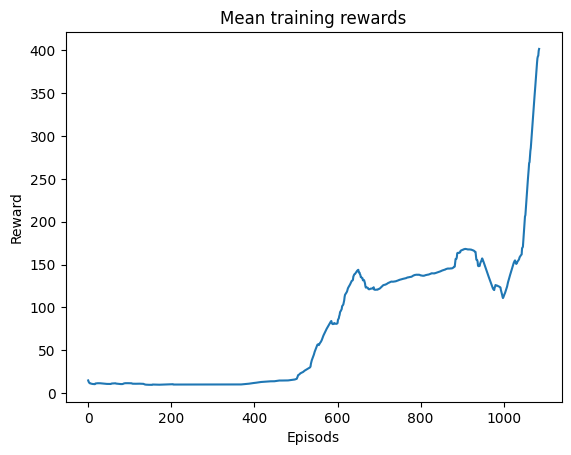

<Figure size 640x480 with 0 Axes>

In [13]:
import gymnasium as gym

set_seed(SEED)
env = gym.make("CartPole-v1", render_mode="rgb_array")
rew_threshold = 400
buffer = Experience_replay_buffer()
agent_ddqn = DDQN_agent(env, rew_threshold, buffer, initial_epsilon=0.7, seed=SEED)

state, _ = env.reset(seed=SEED)
agent_ddqn.train()

In [14]:
set_seed(seed=123)
eval_env = gym.make("CartPole-v1", render_mode="human")
agent_ddqn.seed = 123
agent_ddqn.evaluate(eval_env)

Evaluation cumulative reward:  366.0


4 2
Q network:
Net(
  (activation_function): Tanh()
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)
4 2
Q network:
Net(
  (activation_function): Tanh()
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)
Episode 1527 Mean Rewards 404.14  Episode reward = 500.00   mean loss = 17.29		
Environment solved in 1527 episodes!


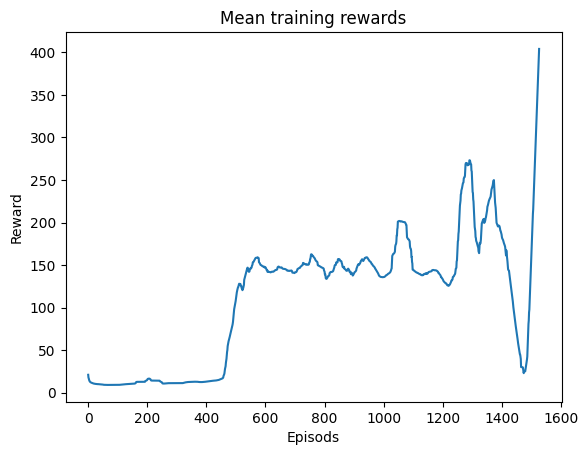

<Figure size 640x480 with 0 Axes>

In [9]:
import gymnasium as gym
set_seed(SEED)
env = gym.make("CartPole-v1", render_mode="rgb_array")
rew_threshold = 400
buffer = Experience_replay_buffer()
agent_dqn = DQN_agent(env, rew_threshold, buffer, initial_epsilon=0.7, seed=SEED)
agent_dqn.train()

In [15]:
set_seed(seed=123)
eval_env = gym.make("CartPole-v1", render_mode="human")
agent_dqn.seed = 123
agent_dqn.evaluate(eval_env)


Evaluation cumulative reward:  500.0
